In [1]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim

import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import librosa

from src.utility import EDA
eda = EDA()

In [2]:
from src.classes import DrumTrackerDataset
dataset = DrumTrackerDataset()

/home/vikram-linux/anaconda3/envs/drum-tracker/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


In [3]:
signal, label = dataset.__getitem__(0)
signal.size()

torch.Size([1, 256, 6])

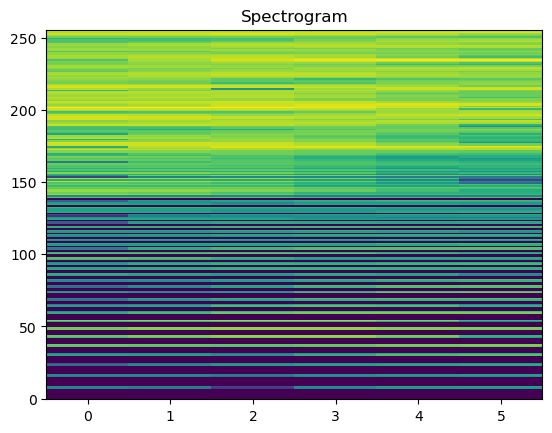

In [4]:
eda.plot_spectrogram(signal.squeeze(0))

In [5]:
from src.classes import ModelTrainer, CNN_Model
cnn_model = CNN_Model()
loss_fn = nn.CrossEntropyLoss()
optim_fn = optim.Adam(params=cnn_model.parameters(), lr=0.01)
trainer = ModelTrainer(cnn_model, loss_fn, optim_fn, dataset)


In [6]:
trainer.train_model()

Training Device = cuda
Random seed = 42
Splitting dataset...
Initializing dataloader for training...


ValueError: batch_size should be a positive integer value, but got batch_size=(32,)

In [ ]:
mel_spec_trans = T.MelSpectrogram(
    sample_rate = 16000,
    n_fft = 256,
    hop_length = 256 // 8,
    n_mels = 256
)

In [ ]:
signal, rate = torchaudio.load('data/clean/hi-hat_001.wav')
print(signal.size())
print(f'Rate = {rate}')

In [ ]:
mel_spec = mel_spec_trans(signal).unsqueeze(0)
input_size = torch.tensor(mel_spec.size())
input_size

In [ ]:
eda.plot_spectrogram(mel_spec.squeeze(0).squeeze(0))

In [ ]:
conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = 16,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

conv2 = nn.Conv2d(
            in_channels = 16,
            out_channels = 32,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

conv3 = nn.Conv2d(
            in_channels = 32,
            out_channels = 64,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

conv4 = nn.Conv2d(
            in_channels = 64,
            out_channels = 128,
            kernel_size = 3,
            stride = 1,
            padding = 2
        )

relu = nn.ReLU()
maxpool =  nn.MaxPool2d(kernel_size=2)

flatten = nn.Flatten()

linear1 = nn.Linear(in_features=4352, out_features=128)
linear2 = nn.Linear(in_features=128, out_features=16)
linear3 = nn.Linear(in_features=16, out_features=3)

output = maxpool(relu(conv1(mel_spec)))
print(f'Conv1 Ouput = {output.size()}')

output = maxpool(relu(conv2(output)))
print(f'Conv2 Ouput = {output.size()}')

output = maxpool(relu(conv3(output)))
print(f'Conv3 Ouput = {output.size()}')

output = maxpool(relu(conv4(output)))
print(f'Conv4 Ouput = {output.size()}')
print(output.size()[1] * output.size()[2] * output.size()[3])

output = flatten(output)
print(f'Flatten Output = {output.size()}')

output = linear1(output)
print(f'Linear1 Output = {output.size()}')

output = linear2(output)
print(f'Linear2 Output = {output.size()}')

output = linear3(output)
print(f'Linear3 Output = {output.size()}')

In [ ]:
dataset.__getitem__(0)